# Imports

In [1]:
import time
import torch
from torch import nn, optim
from tqdm import tqdm
from dataset import WheatSegDatasetUnet
from unet import UNet
import cv2
import os
from segmentation_models_pytorch.losses import TverskyLoss
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
import pytorch_lightning as pl
import wandb
# Import TverskyLoss from torch

from utils import *
from definitions import *

# Select MPS if available, otherwise CPU
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")
VANILLA_UNET_MODEL_SAVE_PATH = "vanilla_unet.pth"

Using device: mps


# DataLoaders, Model, Loss & Optimizer

In [2]:
train_dataset = WheatSegDatasetUnet(
    images_dir="/Users/guyperets/Documents/DeepLearning_ImageProcessing/FinalProject/final_IP_project/data_unet/train_img",
    masks_dir="/Users/guyperets/Documents/DeepLearning_ImageProcessing/FinalProject/final_IP_project/data_unet/train_masks"
)

val_dataset = WheatSegDatasetUnet(
    images_dir="/Users/guyperets/Documents/DeepLearning_ImageProcessing/FinalProject/final_IP_project/data_unet/val_img",
    masks_dir="/Users/guyperets/Documents/DeepLearning_ImageProcessing/FinalProject/final_IP_project/data_unet/val_masks"
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False)

print(f"number of training samples: {len(train_loader.dataset)}")
print(f"number of validation samples: {len(val_loader.dataset)}")
print(f"dataloaders created with batch size {BATCH_SIZE} and {NUM_WORKERS} workers")
print(f"=== Dataloaders Summary ===")
print(f"Train Loader: {len(train_loader)} batches")
print(f"Validation Loader: {len(val_loader)} batches")


model   = UNet().to(device)
bce_loss = nn.BCEWithLogitsLoss()
tversky_loss = TverskyLoss(mode='binary', alpha=TVERSKY_ALPHA, beta=TVERSKY_BETA)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"=== Model Summary ===")
print(model)

Found 2699 matching image-mask pairs in /Users/guyperets/Documents/DeepLearning_ImageProcessing/FinalProject/final_IP_project/data_unet/train_img
Found 674 matching image-mask pairs in /Users/guyperets/Documents/DeepLearning_ImageProcessing/FinalProject/final_IP_project/data_unet/val_img
number of training samples: 2699
number of validation samples: 674
dataloaders created with batch size 64 and 8 workers
=== Dataloaders Summary ===
Train Loader: 43 batches
Validation Loader: 11 batches
Using device cpu for AveragePrecision metric
=== Model Summary ===
UNet(
  (val_ap): BinaryAveragePrecision()
  (downs): ModuleList(
    (0): DoubleConv(
      (net): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (net): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3),

In [3]:
# Debug: Test dataset creation and access
print(f"Train dataset length: {len(train_dataset)}")
print(f"Val dataset length: {len(val_dataset)}")

# Try to access the first item
try:
    first_item = train_dataset[0]
    print(f"First item shapes - Image: {first_item[0].shape}, Mask: {first_item[1].shape}")
    print("Dataset access successful!")
except Exception as e:
    print(f"Error accessing first item: {e}")
    
# Check if datasets have any items
if len(train_dataset) == 0:
    print("ERROR: Train dataset is empty!")
if len(val_dataset) == 0:
    print("ERROR: Validation dataset is empty!")
    

Train dataset length: 2699
Val dataset length: 674
First item shapes - Image: torch.Size([3, 128, 128]), Mask: torch.Size([1, 128, 128])
Dataset access successful!


In [4]:
# first_item = first_item[1].cpu().numpy()  # Convert to numpy for precision calculation
# assert image_precision(first_item, first_item) > .95
# assert image_precision(first_item, np.zeros_like(first_item)) == 0.0
# assert np.isclose(image_precision(np.ones_like(first_item), np.ones_like(first_item)), 1.0)

# Training Loop

In [5]:
ckpt_cb = ModelCheckpoint(  dirpath="checkpoints",
                            filename="unet-{epoch:02d}-{val_ap:.3f}",
                            monitor="val_ap",
                            mode="max",
                            save_top_k=3,
                            every_n_epochs=1,)
wandb_logger = WandbLogger(project="wheat-detection-unet", log_model="all")
trainer = pl.Trainer(
    max_epochs=NUM_EPOCHS,
    accelerator="auto",
    callbacks=[ckpt_cb],
    logger=wandb_logger,
    enable_checkpointing= True,
    enable_progress_bar=True,
    enable_model_summary=True
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [6]:
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

wandb: Currently logged in as: guyperet (guyperet-ben-gurion-university-of-the-negev) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/Users/guyperets/.pyenv/versions/wheat-env/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /Users/guyperets/Documents/DeepLearning_ImageProcessing/FinalProject/final_IP_project/src/checkpoints exists and is not empty.

  | Name       | Type                   | Params | Mode 
--------------------------------------------------------------
0 | val_ap     | BinaryAveragePrecision | 0      | train
1 | downs      | ModuleList             | 4.7 M  | train
2 | pool       | MaxPool2d              | 0      | train
3 | bottleneck | DoubleConv             | 14.2 M | train
4 | ups        | ModuleList             | 12.2 M | train
5 | final_conv | Conv2d                 | 65     | train
--------------------------------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.127   Total estimated model params size (MB)
63        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/guyperets/.pyenv/versions/wheat-env/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


AP: 0.19156406819820404


/Users/guyperets/.pyenv/versions/wheat-env/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/guyperets/.pyenv/versions/wheat-env/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

AP: 0.5488938093185425


Validation: |          | 0/? [00:00<?, ?it/s]

AP: 0.5519236922264099


Validation: |          | 0/? [00:00<?, ?it/s]

AP: 0.5626975893974304


Validation: |          | 0/? [00:00<?, ?it/s]

AP: 0.559074342250824


Validation: |          | 0/? [00:00<?, ?it/s]

AP: 0.568747341632843


Validation: |          | 0/? [00:00<?, ?it/s]

AP: 0.562142014503479


Validation: |          | 0/? [00:00<?, ?it/s]

AP: 0.5667325258255005


Validation: |          | 0/? [00:00<?, ?it/s]

AP: 0.5738319754600525


Validation: |          | 0/? [00:00<?, ?it/s]

AP: 0.5866531729698181


Validation: |          | 0/? [00:00<?, ?it/s]

AP: 0.619251549243927


Validation: |          | 0/? [00:00<?, ?it/s]

AP: 0.6507794260978699


Validation: |          | 0/? [00:00<?, ?it/s]

AP: 0.6429734230041504


Validation: |          | 0/? [00:00<?, ?it/s]

AP: 0.7020276784896851


Validation: |          | 0/? [00:00<?, ?it/s]

AP: 0.7111069560050964


Validation: |          | 0/? [00:00<?, ?it/s]

AP: 0.737274169921875


Validation: |          | 0/? [00:00<?, ?it/s]

AP: 0.7391934394836426


Validation: |          | 0/? [00:00<?, ?it/s]

AP: 0.7439823150634766


Validation: |          | 0/? [00:00<?, ?it/s]

AP: 0.7625740766525269


Validation: |          | 0/? [00:00<?, ?it/s]

AP: 0.7577886581420898


Validation: |          | 0/? [00:00<?, ?it/s]

AP: 0.780170738697052


`Trainer.fit` stopped: `max_epochs=20` reached.


In [9]:
wandb.finish()

wandb: ERROR Control-C detected -- Run data was not synced


KeyboardInterrupt: 

# Test On Unannotated

In [7]:
UNANNOTATED_IMAGES_DIR = "/Users/guyperets/Documents/DeepLearning_ImageProcessing/FinalProject/final_IP_project/data/unannotated"
# Pass the unannotated images through the model, save the predictions
def preprocess_unannotated_images(unannotated_dir):
    # Resize to 256x256, normalize, and convert to tensor
    unannotated_images = []
    for img_name in os.listdir(unannotated_dir):
        img_path = os.path.join(unannotated_dir, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_LINEAR)
            img = img / 255.0
            img_tensor = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)
            unannotated_images.append(img_tensor)
    return torch.stack(unannotated_images)

In [8]:
unannotated_images = preprocess_unannotated_images(UNANNOTATED_IMAGES_DIR)
unannotated_images = unannotated_images.to(device)
# Load the model
loaded_model = UNet().to(device)
loaded_model.load_state_dict(torch.load(VANILLA_UNET_MODEL_SAVE_PATH))
loaded_model.eval()
predictions = []
with torch.no_grad():
    for i in tqdm(range(len(unannotated_images))):
        outputs = loaded_model(unannotated_images)
        predictions.append(outputs.cpu().numpy())

FileNotFoundError: [Errno 2] No such file or directory: '/Users/guyperets/Documents/DeepLearning_ImageProcessing/FinalProject/final_IP_project/data/unannotated'

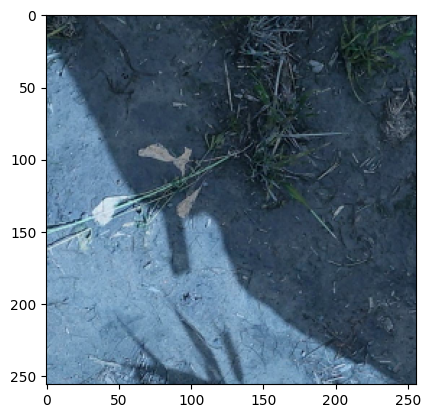

In [ ]:
plt.imshow(unannotated_images[0].cpu().numpy().transpose(1, 2, 0))

In [ ]:
# ! Does not work

# Save predictions
for pred, img in zip(predictions[0], unannotated_images):
    pred_mask = (pred > 0.5).astype(np.uint8)  # Convert to binary mask
    # Add 2 dimensions to the mask, such that it can be stacked with the original image
    pred_mask = np.stack([pred_mask.squeeze(0)] * 3, axis=0).transpose(1, 2, 0)  # Convert to 3-channel mask for visualization
    # Stack horizontally with the original image
    img = img.cpu().numpy().transpose(1, 2, 0)  # Convert to HWC format and scale to [0, 255]
    side_by_side = np.hstack((img, pred_mask))
    cv2.imwrite(f"test_side_by_side/unannotated_side_by_side_{i}.png", side_by_side)


[ WARN:0@11413.674] global loadsave.cpp:848 imwrite_ Unsupported depth image for selected encoder is fallbacked to CV_8U.


In [11]:
TEST_DIR = "/Users/guyperets/Documents/DeepLearning_ImageProcessing/FinalProject/final_IP_project/data_unet/test"
test_imgs = preprocess_unannotated_images(TEST_DIR).to(device)

In [12]:
loaded_model = UNet().to(device)
loaded_model.load_state_dict(torch.load(VANILLA_UNET_MODEL_SAVE_PATH))
loaded_model.eval()
predictions = []
with torch.no_grad():
    for i in tqdm(range(len(test_imgs))):
        outputs = loaded_model(test_imgs)
        predictions.append(outputs.cpu().numpy())

Using device cpu for AveragePrecision metric


100%|██████████| 10/10 [00:01<00:00,  5.34it/s]


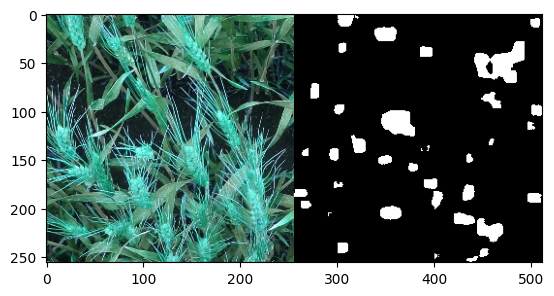

In [15]:
# ! Does not work

# Save predictions
for pred, img in zip(predictions[0], test_imgs):
    pred_mask = (pred > 0.5).astype(np.uint8)  # Convert to binary mask
    # Add 2 dimensions to the mask, such that it can be stacked with the original image
    pred_mask = np.stack([pred_mask.squeeze(0)] * 3, axis=0).transpose(1, 2, 0)  # Convert to 3-channel mask for visualization
    # Stack horizontally with the original image
    img = img.cpu().numpy().transpose(1, 2, 0)  # Convert to HWC format and scale to [0, 255]
    side_by_side = np.hstack((img, pred_mask))
    plt.imshow(side_by_side)